In [1]:
import mlplol
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

We will use the diabetes regression dataset from sklearn

In [2]:
diabetes = sklearn.datasets.load_diabetes()

def split_data_np(features, target, validation_fraction, test_fraction):
    N = features.shape[0]
    inds_shuffled = np.random.permutation(np.arange(0, N))
    train_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction - validation_fraction)))
    val_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction)))
    train_inds = inds_shuffled[0:train_thresh]
    val_inds = inds_shuffled[train_thresh:val_thresh]
    test_inds = inds_shuffled[val_thresh:]

    trainX = features[train_inds, :]
    trainY = target[train_inds]

    valX = features[val_inds, :]
    valY = target[val_inds]

    testX = features[test_inds, :]
    testY = target[test_inds]

    return dict(trainx=trainX, trainy=trainY, valx=valX, valy=valY, testx=testX, testy=testY)


diabetes_split = split_data_np(diabetes.data, diabetes.target, 0.2, 0.2)

In [3]:
# check the shape
diabetes.data.shape

(442, 10)

Make up some random weights and check quotient of gradient vs gradient computed with finite difference method. 

In [4]:
# make some test weights
wtest1 = np.random.normal(0, 1, (diabetes.data.shape[1]+1, 10))
wtest2 = np.random.normal(0, 1, (11, 1))

test_gradients = mlplol.gradient_quotients([wtest1, wtest2], diabetes_split['trainx'],
                diabetes_split['trainy']) # should be arrays of ones

In [5]:
print([i for i in test_gradients])

[array([[1.        , 1.00000111, 1.        , 1.        , 1.        ,
        1.00000089, 1.        , 0.99999713, 1.        , 0.99999946],
       [1.        , 1.00005367, 1.        , 1.        , 1.        ,
        1.00027513, 1.        , 0.99941681, 1.        , 0.99999598],
       [1.        , 1.00031002, 1.        , 1.        , 1.        ,
        1.00132149, 1.        , 0.99897467, 1.        , 0.99905795],
       [1.        , 1.00014019, 1.        , 1.        , 1.        ,
        1.0002657 , 1.        , 0.99922303, 1.        , 0.99996897],
       [1.        , 1.00008838, 1.        , 1.        , 1.        ,
        1.00021317, 1.        , 0.9996776 , 1.        , 0.99992868],
       [1.        , 1.0001231 , 1.        , 1.        , 1.        ,
        1.0009087 , 1.        , 0.99694223, 1.        , 0.99981074],
       [1.        , 1.00018495, 1.        , 1.        , 1.        ,
        1.0009455 , 1.        , 0.99937296, 1.        , 0.99980907],
       [1.        , 0.9999039 , 1.      

We train a model.

In [6]:
diabetes_nn = mlplol.NNregressor_onelayer(activation_function = 'relu')
diabetes_nn.estimate_weights(diabetes_split['trainx'], diabetes_split['trainy'], diabetes_split['valx'],
                             diabetes_split['valy'], n_hidden=100,
                              iterations=100, patience=10, rate=0.001,
                              verbose=False, weight_initialization_factors=None)

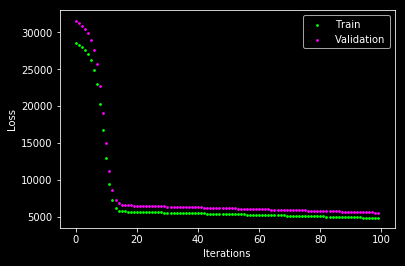

In [7]:
plt.style.use("dark_background")
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

Check test loss

In [8]:
test_pred = diabetes_nn.predict(diabetes_split['testx'])
test_loss = mlplol.squared_loss(test_pred, diabetes_split['testy'])
print('test loss: ', test_loss)

test loss:  4871.354797290226


We can also try auto encoding, demonstrated using the iris dataset.

In [9]:
iris = sklearn.datasets.load_iris()

In [10]:
iris.data.shape

(150, 4)

In [11]:
iris_split = split_data_np(iris.data, iris.target, 0.2, 0.2)

In [12]:
iris_ae = mlplol.NNregressor_onelayer(activation_function = 'softsign')
iris_ae.estimate_weights(iris_split['trainx'], iris_split['trainx'], iris_split['valx'],
                             iris_split['valx'], n_hidden=2, 
                              iterations=1000, patience=10, rate=0.001, 
                              verbose=False, weight_initialization_factors=None)

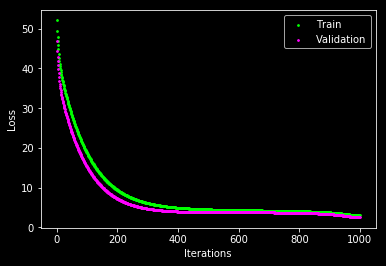

In [13]:
plt.style.use("dark_background")
plt.scatter(np.arange(iris_ae.iterations), iris_ae.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(iris_ae.iterations), iris_ae.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

In [14]:
test_reconstructions = iris_ae.predict(iris_split['testx'])
test_loss_ae = mlplol.squared_loss(iris_split['testx'], test_reconstructions)
print('test loss post train: ', test_loss_ae)

test loss post train:  2.3434337172123234


In [15]:
iris_code = iris_ae.encode(iris.data)

In [16]:
iris_code.shape

(150, 2)

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)
pca.fit(iris.data)
iris_pca = pca.transform(iris.data)

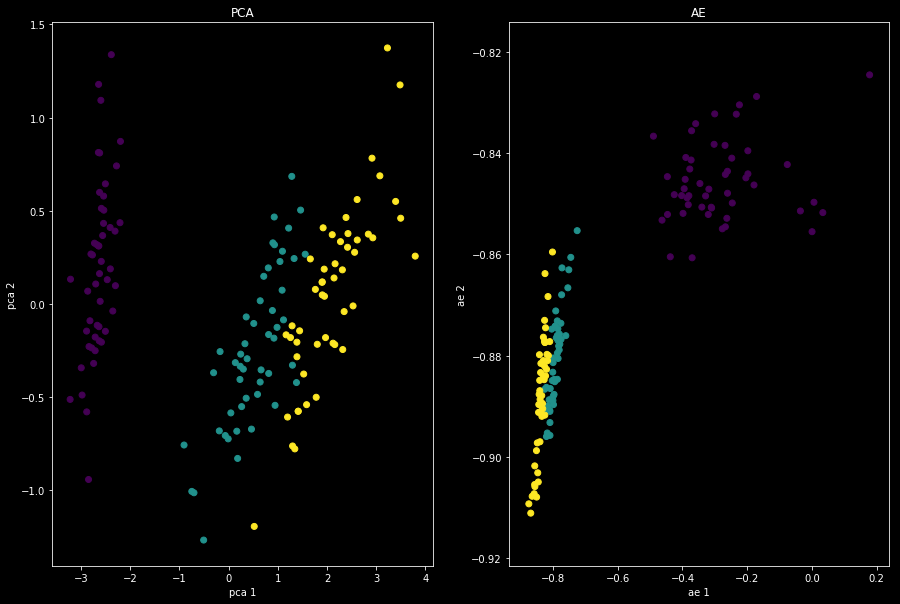

In [19]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].scatter(iris_pca[:, 0], iris_pca[:, 1], c=iris.target)
ax[0].set_xlabel('pca 1')
ax[0].set_ylabel('pca 2')
ax[0].set_title('PCA')

ax[1].scatter(iris_code[:, 0], iris_code[:, 1], c=iris.target)
ax[1].set_xlabel('ae 1')
ax[1].set_ylabel('ae 2')
ax[1].set_title('AE')

plt.show()